Link to dataset:
https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who?search=alcohol+effects

### Load Packages

In [128]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

## Load dataset and clean data - Adam

In [129]:
# import dataset
data = pd.read_csv('Life_Expectancy_Data.csv')

# clean column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# rename gdp column to make data more understandable
data = data.rename(columns={'gdp': 'gdp_per_capita'})

# rename HIV/AIDs column to make it usable
data = data.rename(columns={'hiv/aids': 'hiv_aids'})

# rename thinness 1-19 column to make it usable
data = data.rename(columns={'thinness__1-19_years': 'thinness_1_19_years'})

# rename thinness 5-9 column to make it usable
data = data.rename(columns={'thinness_5-9_years': 'thinness_5_9_years'})

# rename under five deaths column to make it usable
data = data.rename(columns={'under-five_deaths': 'under_five_deaths'})



/var/folders/0x/61vcmsg94cs94n1kc433lq8w0000gn/T/ipykernel_5399/955355231.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/0x/61vcmsg94cs94n1kc433lq8w0000gn/T/ipykernel_5399/955355231.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


In [130]:
# Drop columns with suspect data

# Dropping 'population' column
data.drop(columns=['population', 'bmi', 'infant_deaths', 'percentage_expenditure', 'hepatitis_b', 'alcohol', 'total_expenditure', 'adult_mortality'],inplace=True)
    # population: data inconsistent and inaccurate
    # bmi: max bmi is over 80, which does not make sense -- lots of values like this
    # infant_deaths: mean value is 29-- true world highest value is 27
    # percentage_expenditure: seems very inaccurate, large number of values over 100%
    # adult_mortality: don't want to use this to draw conclusions on life expectancy 

In [131]:
# Additional Cleaning -- Dropping Missing Values

# drop missing gdp, life_expectancy, income_composition_of_resources values, 
data = data.dropna(subset=['gdp_per_capita','income_composition_of_resources'])


In [132]:
# Dropping rows with unreasonable gdp_per_capita values
    # the number 108 is chosen because an outside source confirmed that the lowest
    # gdp per capita during this time period is 108
data = data.loc[data.gdp_per_capita >= 108]

# Dropping rows with unreasonable under_five_deaths values
    # the number 180 is chosen because an outside source confirmed that the highest value should be 225 for this period
data = data.loc[data.under_five_deaths <= 225]

In [133]:
# reset the index numbers

data = data.reset_index(drop=True)

In [134]:
data.isnull().sum()

country                             0
year                                0
status                              0
life_expectancy                     2
measles                             0
under_five_deaths                   0
polio                              10
diphtheria                         10
hiv_aids                            0
gdp_per_capita                      0
thinness_1_19_years                24
thinness_5_9_years                 24
income_composition_of_resources     0
schooling                           0
dtype: int64

In [135]:
data = data.dropna()

In [136]:
data.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
measles                            0
under_five_deaths                  0
polio                              0
diphtheria                         0
hiv_aids                           0
gdp_per_capita                     0
thinness_1_19_years                0
thinness_5_9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [137]:
# add in continents to be a categorical variable
continents_df = pd.read_csv('gdp_lifeExpectancy.csv')
continents = continents_df[['country', 'continent']]
continents.head(1)

,country,continent
0,Afghanistan,Asia


In [138]:
data = pd.merge(data, continents, on='country')

In [139]:
data.head(1)

,country,year,status,life_expectancy,measles,under_five_deaths,polio,diphtheria,hiv_aids,gdp_per_capita,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,continent
0,Afghanistan,2015,Developing,65.0,1154,83,6.0,65.0,0.1,584.25921,17.2,17.3,0.479,10.1,Asia


In [140]:
# dividing data into 80% training, 20% test
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8)) # 80% training, 20% test
test = data.drop(train.index)

In [142]:
# test model
ols_object = sm.ols(formula = 'life_expectancy~schooling*income_composition_of_resources+polio+hiv_aids+np.log(gdp_per_capita)+thinness_1_19_years', data=train)
model = ols_object.fit()

# returning numerical/statistical analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                 1.258e+04
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:18:05   Log-Likelihood:                -44607.
No. Observations:               15773   AIC:                         8.923e+04
Df Residuals:                   15765   BIC:                         8.929e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [143]:
#Computing RMSE on test data
pred_life = model.predict(test)
np.sqrt(((test.life_expectancy - pred_life)**2).mean())

4.037439163968294

Text(0, 0.5, 'Residuals')

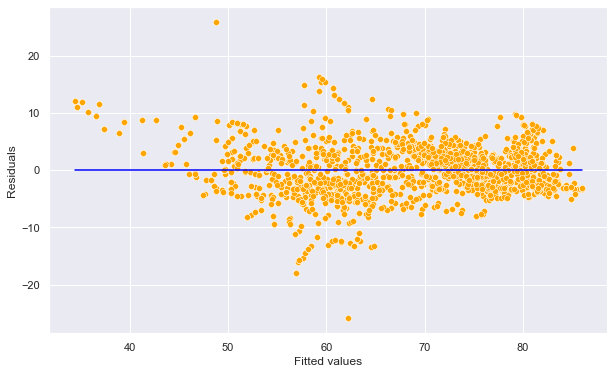

In [144]:
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model.fittedvalues), y=(model.resid),color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(),model.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [145]:
data.iloc[1022:1026]

,country,year,status,life_expectancy,measles,under_five_deaths,polio,diphtheria,hiv_aids,gdp_per_capita,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,continent
1022,Australia,2006,Developed,81.2,0,2,92.0,92.0,0.1,36118.28381,0.7,0.6,0.915,20.3,Oceania
1023,Australia,2006,Developed,81.2,0,2,92.0,92.0,0.1,36118.28381,0.7,0.6,0.915,20.3,Oceania
1024,Australia,2006,Developed,81.2,0,2,92.0,92.0,0.1,36118.28381,0.7,0.6,0.915,20.3,Oceania
1025,Australia,2006,Developed,81.2,0,2,92.0,92.0,0.1,36118.28381,0.7,0.6,0.915,20.3,Oceania


## Variable Selection/VIF - Judd

In [146]:
data.columns

Index(['country', 'year', 'status', 'life_expectancy', 'measles',
       'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids',
       'gdp_per_capita', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling', 'continent'],
      dtype='object')

In [147]:
#Predictors VIF will be caluclated for:

X = train[['measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 
           'gdp_per_capita', 'thinness_1_19_years', 'thinness_5_9_years',
           'income_composition_of_resources', 'schooling']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# add constant column
X = add_constant(X)
# create empty dataframe to input VIF values
vif_data=pd.DataFrame()
# create row for each predictor in X
vif_data['predictor'] = X.columns

# for loop to fill in VIF values 
for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values,i)
    
print(vif_data)

                          predictor        VIF
0                             const  45.321068
1                           measles   1.195306
2                 under_five_deaths   1.608147
3                             polio   2.173499
4                        diphtheria   2.181976
5                          hiv_aids   1.150721
6                    gdp_per_capita   1.451379
7               thinness_1_19_years   9.228177
8                thinness_5_9_years   9.158306
9   income_composition_of_resources   4.798850
10                        schooling   4.824645


In [148]:
data.corrwith(data.life_expectancy)

year                               0.154529
life_expectancy                    1.000000
measles                           -0.173098
under_five_deaths                 -0.517525
polio                              0.470361
diphtheria                         0.487223
hiv_aids                          -0.588924
gdp_per_capita                     0.486544
thinness_1_19_years               -0.580836
thinness_5_9_years                -0.581806
income_composition_of_resources    0.830276
schooling                          0.806966
dtype: float64

**It appears `thinness_1_19_years`, `thinness_5_9_years`, `income_composition_of_resources`, and `schooling` exhibit multicollinearity. Therefore, we will remove `thinness_5_9_years` and `schooling` since they are less correlated with `life_expectancy`.**

In [149]:
# run test model without interactions
ols_object = sm.ols(formula = 'life_expectancy~measles+under_five_deaths+polio+diphtheria+hiv_aids+gdp_per_capita+thinness_1_19_years+income_composition_of_resources', data=train)
model = ols_object.fit()

# returning numerical/statistical analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 1.037e+04
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:18:25   Log-Likelihood:                -45007.
No. Observations:               15773   AIC:                         9.003e+04
Df Residuals:                   15764   BIC:                         9.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [150]:
#Creating a dataframe with all the predictors
X = train[['measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp_per_capita', 'thinness_1_19_years', 'income_composition_of_resources']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
#X_backup = train[['adult_mortality', 'measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp_per_capita', 'thinness_1_19_years', 'income_composition_of_resources']]

In [151]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('life_expectancy~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [152]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [153]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [154]:
models_best = forward_selection()

Processed  8 models on 1 predictors in 0.0757896900177002 seconds.
Processed  7 models on 2 predictors in 0.05480480194091797 seconds.
Processed  6 models on 3 predictors in 0.0527498722076416 seconds.
Processed  5 models on 4 predictors in 0.05381321907043457 seconds.
Processed  4 models on 5 predictors in 0.05441927909851074 seconds.
Processed  3 models on 6 predictors in 0.043215274810791016 seconds.
Processed  2 models on 7 predictors in 0.03324604034423828 seconds.
Processed  1 models on 8 predictors in 0.021373987197875977 seconds.
Total elapsed time: 0.4142298698425293 seconds.


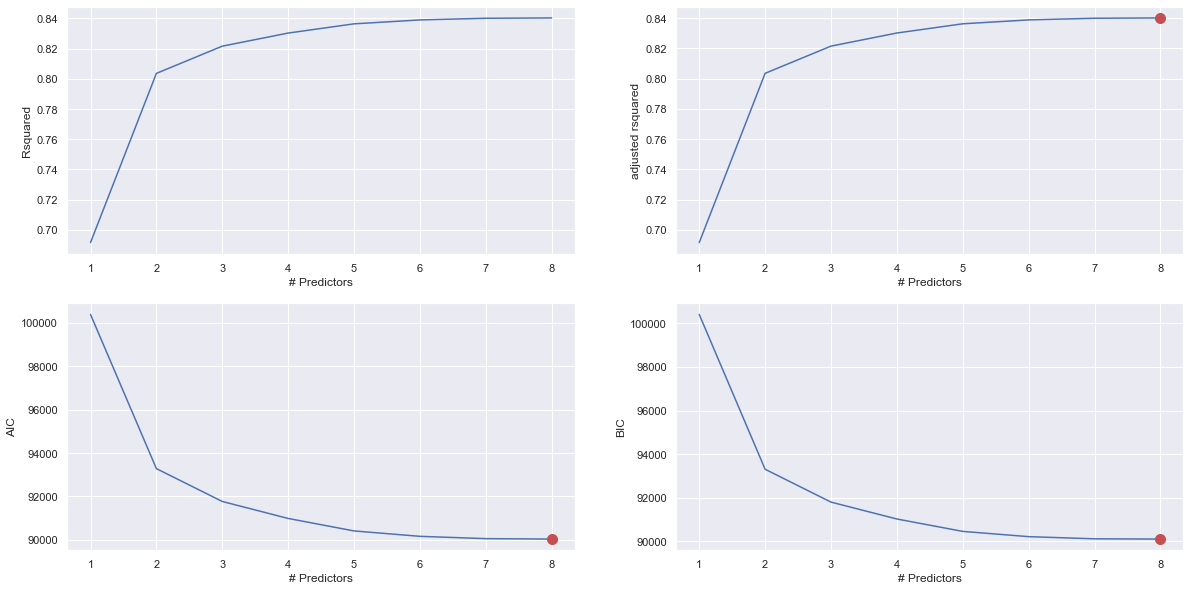

In [155]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [156]:
best_fwd_reg_model = models_best['model'][8]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 1.037e+04
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:18:45   Log-Likelihood:                -45007.
No. Observations:               15773   AIC:                         9.003e+04
Df Residuals:                   15764   BIC:                         9.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          49.7555      0.210    237.223      0.000      49.344      50.167
income_composition_of_resources    27.8134      0.259    107.526      0.000      27.306      28.320
hiv_aids                           -0.5909      0.006   -101.281      0.000      -0.602      -0.580
under_five_deaths                  -0.0345      0.001    -32.029      0.000      -0.037      -0.032
diphtheria                          0.0349      0.002     16.788      0.000       0.031       0.039
thinness_1_19_years                -0.2310      0.010    -22.496      0.000      -0.251      -0.211
gdp_per_capita                   4.261e-05   2.69e-06     15.821      0.000    3.73e-05    4.79e-05
polio                               0.0214      0.002     10.445      0.000       0.017       0.025
measles                          2.593e-05   5.59e-06      4.643      0.000     1.5e-05    3.69e-05
==============================================================================
Omnibus:                     2863.825   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26126.356
Skew:                           0.609   Prob(JB):                         0.00
Kurtosis:                       9.186   Cond. No.                     1.55e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Final Regression Analysis - Alissa

In [157]:
# RMSE of the model using all the predictors
X = train[['measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 
           'gdp_per_capita', 'thinness_1_19_years', 'thinness_5_9_years',
           'income_composition_of_resources', 'schooling']]
model = sm.ols('life_expectancy~' + '+'.join(X.columns),data = train).fit()
pred_life_exp1 = model.predict(test)
print('RMSE:', np.sqrt(((pred_life_exp1 - test.life_expectancy)**2).mean()))
print(model.summary())

RMSE: 3.8713201772391144
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     9468.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:18:51   Log-Likelihood:                -44119.
No. Observations:               15773   AIC:                         8.826e+04
Df Residuals:                   15762   BIC:                         8.835e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [158]:
# Finding the RMSE of the model selected using the forward stepwise selection procedure
pred_life_exp2 = best_fwd_reg_model.predict(test)
print('RMSE:', np.sqrt(((pred_life_exp2 - test.life_expectancy)**2).mean()))
print(best_fwd_reg_model.summary())

RMSE: 4.124510704112843
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 1.037e+04
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:19:06   Log-Likelihood:                -45007.
No. Observations:               15773   AIC:                         9.003e+04
Df Residuals:                   15764   BIC:                         9.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [160]:
# Adding in continent
X_fss = train[['measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 
           'gdp_per_capita', 'thinness_1_19_years', 'income_composition_of_resources', 'continent']]
model_continent = sm.ols('life_expectancy~' + '+'.join(X_fss.columns),data = train).fit()
print(model_continent.summary())
pred_life_exp3 = model_continent.predict(test)
print('RMSE:', np.sqrt(((pred_life_exp2 - test.life_expectancy)**2).mean()))

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     8907.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:19:38   Log-Likelihood:                -43292.
No. Observations:               15773   AIC:                         8.661e+04
Df Residuals:                   15760   BIC:                         8.671e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

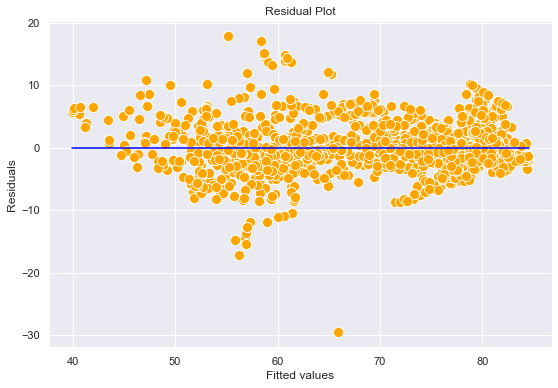

In [168]:
#Plotting residuals vs fitted values
ax = sns.scatterplot(x = (model_continent.fittedvalues), y=(model_continent.resid),color = 'orange')
sns.lineplot(x = [model_continent.fittedvalues.min(),model_continent.fittedvalues.max()],y = [0,0],color = 'blue')
ax.figure.set_figwidth(9)
ax.figure.set_figheight(6)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

After creating two different models (one with all of the predictors and one with the predictors selected from the forward stepwise selection procedure), we calculated the R-squared and RMSE of both. We found that R-squared decreased from 0.875 to 0.861 and RMSE increased from 3.64 to 3.85 when we went from the original model to the forward stepwise selection model. This was the opposite of what we expected, so we decided to visualize the relationships between some of the predictors and the residuals.

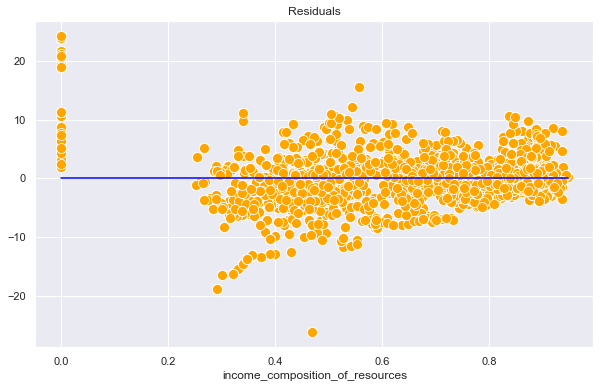

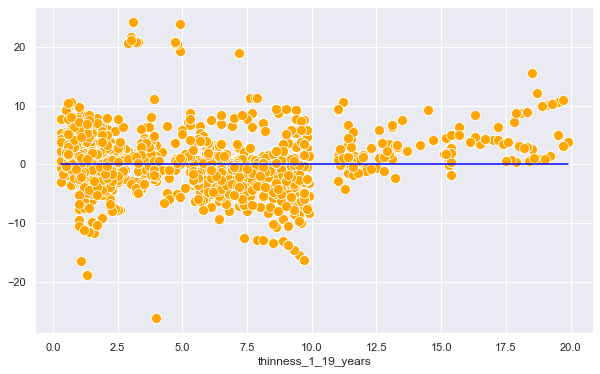

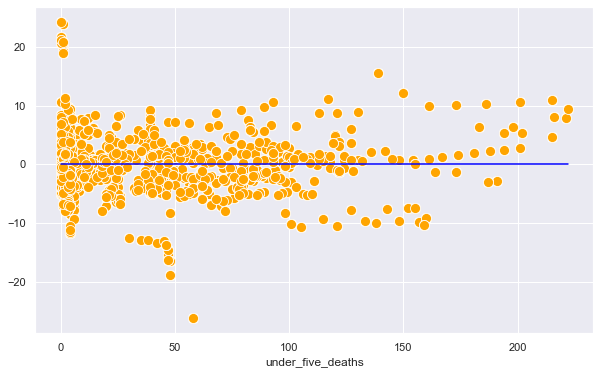

In [161]:
# Quadratic and Cubic transformations needed

# Justification for transformation of income_composition_of_resources
sns.scatterplot(x = train.income_composition_of_resources, y = best_fwd_reg_model.resid, color = 'orange').set_title("Residuals")
sns.lineplot(x = [train.income_composition_of_resources.min(),train.income_composition_of_resources.max()], y = [0,0], color = 'blue')
plt.show()

# Justification for transformation of thinness_1_19_years
sns.scatterplot(x = train.thinness_1_19_years, y = best_fwd_reg_model.resid, color = 'orange')
sns.lineplot(x = [train.thinness_1_19_years.min(),train.thinness_1_19_years.max()], y = [0,0], color = 'blue')
plt.show()

# Justification for transformation of under_five_deaths
sns.scatterplot(x = train.under_five_deaths, y = best_fwd_reg_model.resid, color = 'orange')
sns.lineplot(x = [train.under_five_deaths.min(),train.under_five_deaths.max()], y = [0,0], color = 'blue')
plt.show()


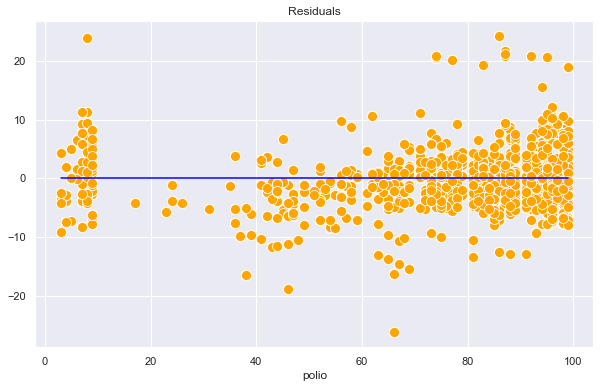

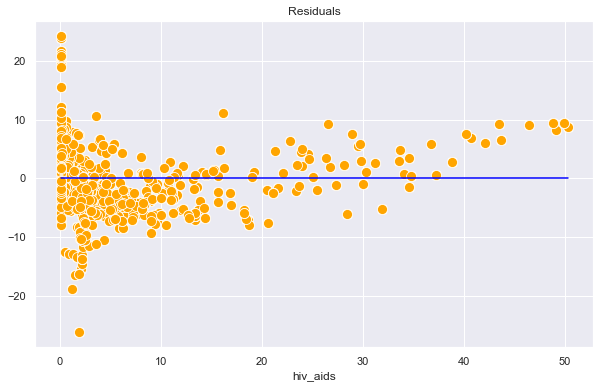

In [162]:
# Quadratic, Cubic, and log transformations needed

# Justification for transformation of polio
sns.scatterplot(x = train.polio, y = best_fwd_reg_model.resid, color = 'orange').set_title("Residuals")
sns.lineplot(x = [train.polio.min(),train.polio.max()], y = [0,0], color = 'blue')
plt.show()

# Justification for transformation of hiv_aids
sns.scatterplot(x = train.hiv_aids, y = best_fwd_reg_model.resid, color = 'orange').set_title("Residuals")
sns.lineplot(x = [train.hiv_aids.min(),train.hiv_aids.max()], y = [0,0], color = 'blue')
plt.show()

After these visualizations, we found that 5 of the 8 predictors (income_composition_of_resources, under_five_deaths, polio, hiv_aids, and thinness_1_19_years) seemed to violate the linearity assumption and needed quadratic and/or cubic transformations. Of those 6, polio and hiv_aids seemed to violate the constant variance assumption and needed a log transformation as well.

In [163]:
# Final model with transformations
ols_object = sm.ols(formula = 'life_expectancy~income_composition_of_resources+I(income_composition_of_resources**2)+I(income_composition_of_resources**3)+measles+under_five_deaths+I(under_five_deaths**2)+I(under_five_deaths**3)+polio+I(polio**2)+I(polio**3)+np.log(polio)+diphtheria+hiv_aids+I(hiv_aids**2)+I(hiv_aids**3)+np.log(hiv_aids)+gdp_per_capita+thinness_1_19_years+I(thinness_1_19_years**2)', data=train)
model = ols_object.fit()

pred_life_exp3 = model.predict(test)
print('RMSE:', np.sqrt(((pred_life_exp3 - test.life_expectancy)**2).mean()))
print(model.summary())

RMSE: 3.062850563181664
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     8739.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:21:45   Log-Likelihood:                -40185.
No. Observations:               15773   AIC:                         8.041e+04
Df Residuals:                   15753   BIC:                         8.056e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [164]:
reset_index_train = train.reset_index()
reset_index_train

,index,country,year,status,life_expectancy,measles,under_five_deaths,polio,diphtheria,hiv_aids,gdp_per_capita,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,continent
0,310,Albania,2003,Developing,72.8,8,1,97.0,97.0,0.1,189.681557,1.9,2.0,0.674,10.7,Europe
1,1591,Bangladesh,2007,Developing,68.6,2924,201,96.0,94.0,0.1,541.651484,19.5,2.1,0.513,8.6,Asia
2,2506,Brazil,2000,Developing,75.0,36,127,99.0,98.0,0.1,3739.119360,3.4,3.4,0.677,14.1,Americas
3,10346,Lebanon,2013,Developing,74.9,1761,1,75.0,81.0,0.1,846.285153,4.8,4.8,0.766,13.3,Asia
4,798,Argentina,2009,Developing,75.6,3,11,97.0,94.0,0.1,8161.369660,1.0,0.9,0.794,16.5,Americas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15768,9896,Jordan,2006,Developing,72.8,1,4,98.0,98.0,0.1,2537.349000,3.9,3.8,0.733,13.7,Asia
15769,7647,Guinea,2006,Developing,55.6,4,49,53.0,57.0,2.6,296.683820,9.1,9.1,0.356,7.1,Africa
15770,12826,Mozambique,2001,Developing,49.5,7085,132,72.0,73.0,13.4,256.441487,4.1,4.0,0.298,5.8,Africa
15771,11274,Malawi,2000,Developing,43.1,304,84,73.0,75.0,25.5,153.259487,8.0,7.9,0.391,10.7,Africa


In [165]:
#Studentized residuals
out = model.outlier_test()
out

,student_resid,unadj_p,bonf(p)
310,-0.244279,0.807018,1.0
1591,0.118716,0.905502,1.0
2506,1.768717,0.076960,1.0
10346,0.063280,0.949545,1.0
798,-0.735348,0.462139,1.0
...,...,...,...
9896,-0.583047,0.559870,1.0
7647,0.944889,0.344730,1.0
12826,0.688597,0.491087,1.0
11274,-0.579741,0.562098,1.0


In [166]:
#Computing the leverage statistic for each observation
influence = model.get_influence()
leverage = influence.hat_matrix_diag
#Average leverage of points
average_leverage = (model.df_model+1)/model.nobs
average_leverage
# Determine the cutoff for high leverage - general convention is 4x the average leverage
cutoff = 4*((model.df_model+1)/model.nobs)
#Number of high leverage points in the dataset
np.sum(leverage>cutoff)

425

In [169]:
#Dropping influential points from data
train_filtered = reset_index_train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],(np.where(leverage>cutoff)[0])))

In [175]:
# final model with influential points dropped
ols_object = sm.ols(formula = 'life_expectancy~continent+income_composition_of_resources+I(income_composition_of_resources**2)+I(income_composition_of_resources**3)+measles+under_five_deaths+I(under_five_deaths**2)+I(under_five_deaths**3)+polio+I(polio**2)+I(polio**3)+np.log(polio)+diphtheria+hiv_aids+I(hiv_aids**2)+I(hiv_aids**3)+np.log(hiv_aids)+gdp_per_capita+thinness_1_19_years+I(thinness_1_19_years**2)', data=train_filtered)
model = ols_object.fit()

pred_life_exp3 = model.predict(test)
print('RMSE:', np.sqrt(((pred_life_exp3 - test.life_expectancy)**2).mean()))
print(model.summary())

RMSE: 2.961933871851786
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     7648.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:25:16   Log-Likelihood:                -39766.
No. Observations:               15773   AIC:                         7.958e+04
Df Residuals:                   15749   BIC:                         7.976e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [176]:
print("rse:", np.sqrt(model.mse_resid))

rse: 3.013003320967739


In [177]:
# Final in-between model
ols_object = sm.ols(formula = 'life_expectancy~income_composition_of_resources+I(income_composition_of_resources**2)+measles+under_five_deaths+polio+diphtheria*continent+hiv_aids+np.log(gdp_per_capita)', data=train_filtered)
model = ols_object.fit()

pred_life_exp_test = model.predict(test)
print("RSE:", np.sqrt(model.mse_resid))
print('RMSE:', np.sqrt(((pred_life_exp_test - test.life_expectancy)**2).mean()))
print(model.summary())

RSE: 3.3880802380796715
RMSE: 3.2638403938003604
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     8488.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:25:20   Log-Likelihood:                -41620.
No. Observations:               15773   AIC:                         8.327e+04
Df Residuals:                   15756   BIC:                         8.340e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------